# Winning probability of "First Orchard"
**Author:** Tobias Windisch (http://tobias-windisch.de)


Tiny analysis of the winning probability of the kids game [First Orchard](https://www.haba.de/de_DE/meine-ersten-spiele-erster-obstgarten--003177). Analysis inspired by my two year old daugher asking me, how likely the raven wins.

<img src="https://edge-haba.azureedge.net/cs/products/23/91//1000x1000.jpg?1602036902000" width=200>

## Rules
The rules of the game are pretty simple (well, its a kids game): There are `n` different trees in the orchard each one having `m` many fruits. 
Each round, the kids draw in a round-robin fashion a (fair) dice, which has a raven symbol, one symbol for each fruit, and a basket symbol. Depending on what the dice shows, the following happens:

* If the dice shows one of the fruits, the respective kids can plow one of the remaining fruits of the tree and put it into a basket. 
* If the dice shows the basket symbol, the respective kid can freely select one of the trees it wants to plow. 
* If the dice shows the raven symbol, the raven character moves one step forward.

If the raven exceeds its allowed moves, the raven wins. If all trees are empty, the kids win.

<img src="https://edge-haba.azureedge.net/cs/products/21/02/15/100x100.jpg?1595039736000" width=200>


Now, the question my Daughter and me had after playing a couple of rounds: **Whats the probability that the kids win the game**?

Here is an easy back on the napkin calculation: The kids should win more often as (on average), 5 fruits are collected for each raven moves. That means, after $5$ raven moves, $25$ fruits should have been collected. As there are only 16 fruits, the kids should have (very roughly, as fruits can be diced that are already plowed) a chance of $\frac{16}{25}=0.64$ to win. But whats the **exact** probability?

I first started a combinatorial approach to compute the probability, but the existence of the basket symbol allows different strategies and writing down a combinatorial formula for the winning probability seems infeasible. I also mailed Haba (ticket **00529590|DE-KA-PA**) and they have no clue as well about the winning probability, but "they designed the game such that the kids win with higher probability".




## Dynamic programming

As the basket sign makes any combinatorial approach to compute the winning probability infeasible, we approach an dynamic programming approach [Dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming) is a mathematical optimization method that tries to solve a problem by splitting it into smaller and easier to solve problems in a recursive manner. Games provide a rich source to apply dynamic programming as enumerating their state space allows to compute the probability of every possible game outcome. 

### Model for the game
For our situation here, we can model the fruits on the tree as element of $[f]^t$, where $t$ denotes the number of trees and $f$ the maximal number of fruits on every tree. For the original game, $f=t=4$. Additionally, the position of the raven can be seed as a number in $[r]$ , where $0$ means the raven reaches the garden and $r$ denotes the starting position (with $r=5$ in the game). All in all, every state of the game can be interpreted as an element from $[r]\times[f]^t$


Now, consider the the setting of the original game, i.e. $f=t=4$ and $r=5$ and assume that a game is in the the state $(2, 4, 0, 2, 3)$, that is. 

In [3]:
import matplotlib.pyplot as plt

In [4]:
import networkx as nx

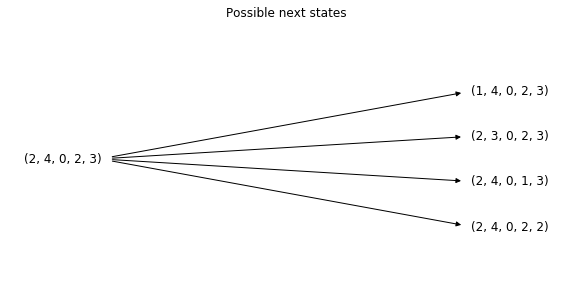

In [5]:
G = nx.MultiDiGraph()

G.add_node(1, label=r"(2, 4, 0, 2, 3)", position=(-1, 0))
G.add_node(2, label=r"(1, 4, 0, 2, 3)", position=(1, 1.5))
G.add_node(3, label=r"(2, 3, 0, 2, 3)", position=(1, 0.5))
G.add_node(4, label=r"(2, 4, 0, 1, 3)", position=(1, -0.5))
G.add_node(5, label=r"(2, 4, 0, 2, 2)", position=(1, -1.5))
G.add_edges_from([(1, 2), (1, 3), (1, 4), (1, 5)]) 

labels = {node: G.node[node]['label'] for node in G.nodes()}
node_positions = {node: G.node[node]['position'] for node in G.nodes()}


label_positions = {n: (pos[0]+pos[0]*0.2, pos[1]) for n, pos in node_positions.items()}
pos = nx.spring_layout(G, pos=node_positions, fixed=node_positions.keys())

fig, ax = plt.subplots(figsize=(10, 5))

ax.set_ylim([-3, 3])
ax.set_xlim([-1.5, 1.5])

nx.draw(G, pos, node_color='white', ax=ax, node_size=500)
nx.draw_networkx_labels(G, label_positions, labels=labels, ax=ax)
ax.set_title('Possible next states');

Into whitch state the games traverses to depends on the outcome of the dice and the basket-"strategy" of the player. One possible basket-strategy could be to always reduce the tree having most fruits. In this case, the traversal probabilities would look like this:

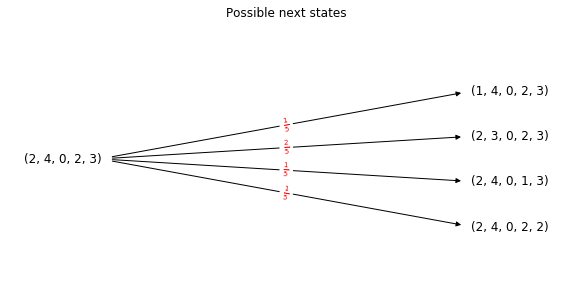

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylim([-3, 3])
ax.set_xlim([-1.5, 1.5])

traversals = {
    (1, 2): r'$\frac{1}{5}$', 
    (1, 3): r'$\frac{2}{5}$',
    (1, 4): r'$\frac{1}{5}$',
    (1, 5): r'$\frac{1}{5}$' 
}

nx.draw(G, pos, node_color='white', ax=ax, node_size=500)
nx.draw_networkx_labels(G, label_positions, labels=labels, ax=ax)
nx.draw_networkx_edge_labels(G, pos, edge_labels=traversals,font_color='red')
ax.set_title('Possible next states');



**Note**: Actually, all probabilities would be $\frac{\cdot}{6}$ and there would be an additional edge from the current state to itself of probability $\frac{1}{6}$ (namely if the fruit is diced whose tree is already empty). However, its easy to see that those can be easily ignored and the probabilities can be rewritten as stated above).

Having this, the **dynamic programming magic** applies: Assume that we would now the winning probability of all subsequent states, then the winning probability of the current state would be

$$p_{2, 4, 0, 2, 3} = 
\frac{1}{5}\cdot p_{1, 4, 0, 2, 3} + 
\frac{2}{5}\cdot p_{2, 3, 0, 2, 3} +
\frac{1}{5}\cdot p_{2, 4, 0, 1, 3} + 
\frac{1}{5}\cdot p_{2, 4, 0, 2, 2} $$

From there, we can preceed recursively until we reach states where we know the probabilities.
These are the states where the kids win, namely states of the form $(i, 0, 0, 0, 0)$ with $i>0$ (all trees plowed and raven has still some moves to go). Here, we have $p_{i, 0, 0, 0, 0}=1$. On the other hand, states where the first dimension is $0$ and at least one of the others is strictily greater than zero, the raven beats the kids, and hence their winning probability is $0$. Any state can be tracked back to exactly one of those state where we know the probability. Multipliying those probabilities with the edge probabilities, the winning probabilty of any state can be computed (see also 
[this](https://math.stackexchange.com/questions/1955888/odds-of-winning-orchard-game) stack overflow article).

### State space

First, we need an object which represents the state of the game and which allows us to enumerate possible next states:

In [7]:
import numpy as np

In [8]:
class State(object):
    """
    First dimension is raven
    """
    def __init__(self, fills):
        self.fills = fills
        self.dim = self.fills.shape[0]
        
    def get_next_states(self, strategy):
        for i in range(self.dim):
            if self.fills[i] > 0:
                yield self.decrease(i)        
        yield strategy(self)
        
    def decrease(self, i):
        fills = np.array(self.fills)
        fills[i] = fills[i] - 1
        return State(fills)

### Strageties
The next ingredient is a strategy. We implement this as a function which consumes a state and outputs a state in the set of the next states where the fruits are decreased (moving the raven one forward is not allowed, and this would also not be a good winning-strategy...).

The first (and probably the best?) strategy that comes into mind is to always plow from the tree having most fruits. We will call this the **argmax-strategy**:

In [9]:
def strategy_argmax(state):
    selection = 1 + state.fills[1:].argmax()
    return state.decrease(selection)

### State space enumeration

Now, lets define an object that compute the winning probability from the start position by recursively computing the winning probability for any state in the game - starting from states where we know the probability already.

In [10]:
class Game(object):
    
    def __init__(self, n_raven_moves=5, n_trees=4, n_fruits=5, strategy=strategy_argmax):
        
        fills = np.repeat(n_fruits, n_trees)
        fills = np.insert(fills, 0, n_raven_moves)
        self.init_state = State(fills)
        
        self.strategy = strategy
        self.p = np.zeros(shape=self.init_state.fills + 1)-np.inf  
        
        # Raven wins
        self.p[0] = 0   
        
        # Kids win
        self.p[tuple([slice(1,self.init_state.fills[0]+1)]+ [0]*(self.init_state.dim-1))] = 1  
    
    def _compute_probability_for_state(self, state):
        """
        Computes the Winning probability of the kids at the given state by using the winning 
        probabilities of the next states multiplied with the traversal probabilities induces 
        by the strategy
        """
        neighbor_states = list(state.get_next_states(self.strategy))
        
        return (1/len(neighbor_states))*sum(
            [
                self._get_probability(neighbor) for neighbor in neighbor_states
            ]
        )
    
    def _get_probability(self, state):
        """
        Returns the probability that the kids win from the given state. 
        If it is not computed already, it will be computed before returning
        """
        p = self.p[tuple(state.fills)]
        
        if p < 0:
            p = self._compute_probability_for_state(state)  
            self.p[tuple(state.fills)] = p
        return p
    
    def compute_win_probability(self):
        return self._get_probability(self.init_state)

### Compute probability of original game

Alright, first of all, lets compute the winning probability of the original setting, where we have $5$ raven moves and $4$ fruits on $4$ trees and lets use the argmax-strategy as defined above:

In [11]:
original_game = Game(n_raven_moves=5, n_trees=4, n_fruits=4, strategy=strategy_argmax)

In [12]:
original_game.compute_win_probability()

0.6313573066006347

So the kids will beat the raven with a probability of **roughly 63%.** to win (very close to our estimate of 64% from above).

## Configurations with four trees

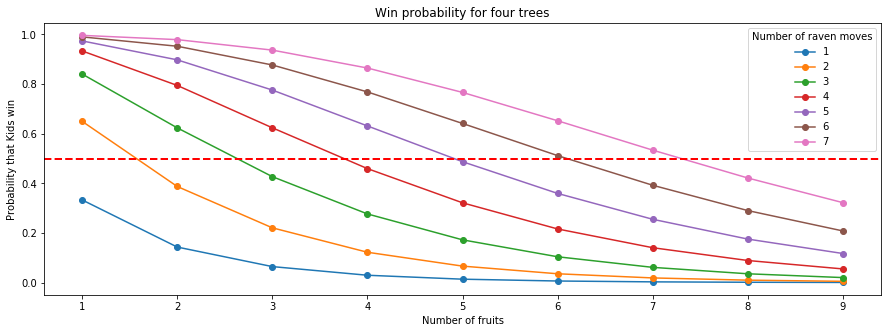

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))

fruits = range(1, 10)
raven_moves = range(1, 8)

for n_raven_moves in raven_moves:
    
    probas = [
        Game(n_raven_moves=n_raven_moves, n_trees=4, n_fruits=i).compute_win_probability() for i in fruits
    ]    
    ax.plot(fruits, probas, label='{}'.format(n_raven_moves), marker='o')
    
ax.axhline(0.5, linewidth=2, color='red', linestyle='--')

ax.set_xlabel('Number of fruits')
ax.set_ylabel('Probability that Kids win')
ax.legend(title="Number of raven moves")
ax.set_title('Win probability for four trees');

## Configurations with five raven moves

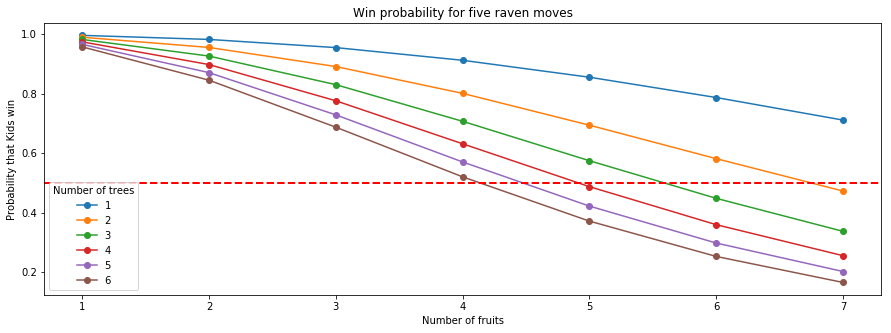

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))

fruits = range(1, 8)
trees = range(1, 7)

for n_trees in trees:
    
    probas = [
        Game(n_raven_moves=5, n_trees=n_trees, n_fruits=i).compute_win_probability() for i in fruits
    ]    
    ax.plot(fruits, probas, label='{}'.format(n_trees), marker='o')
    
ax.axhline(0.5, linewidth=2, color='red', linestyle='--')

ax.set_xlabel('Number of fruits')
ax.set_ylabel('Probability that Kids win')
ax.legend(title="Number of trees")
ax.set_title('Win probability for five raven moves');

The number of trees is not a real game changer (which is clear, as more trees make the raven move also more unlikely). They even could have used `6` trees and the kids would still beat the raven (on average).

## Minimal number of raven moves

Given a number of fruits and a number of trees, what is the smallest number of raven moves such that the kids still win on average?

In [15]:
from itertools import product
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [61]:
trees = range(1, 6)
fruits = range(1, 8)

Lets compute for each game configuration the minimal number of raven moves required for a kids victory:

In [62]:
raven_moves = []
for n_trees, n_fruits in product(trees, fruits):
    n_raven_moves = 1
    while True:
        if Game(n_trees=n_trees, n_raven_moves=n_raven_moves, n_fruits=n_fruits,).compute_win_probability() > 0.5:
            raven_moves.append(n_raven_moves)
            break
        else:
            n_raven_moves = n_raven_moves + 1

In [63]:
T, F = np.meshgrid(trees, fruits)

In [80]:
R = np.array(raven_moves).reshape(7, 5)

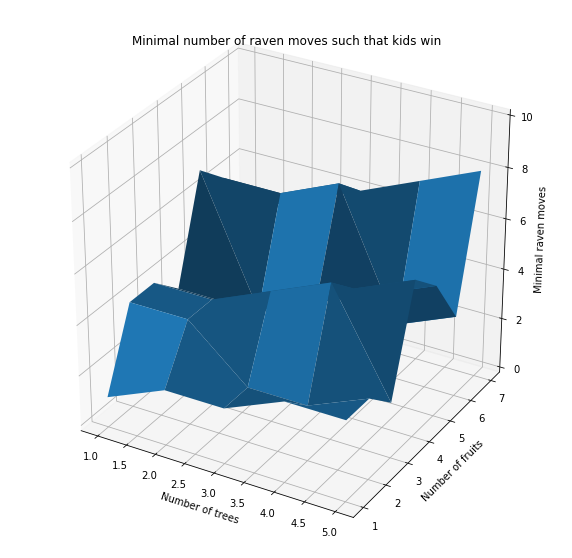

In [92]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
ax.plot_surface(T, F, R)

ax.set_zlim([0, 10])
ax.set_xlabel('Number of trees')
ax.set_ylabel('Number of fruits')
ax.set_zlabel('Minimal raven moves')
ax.set_title('Minimal number of raven moves such that kids win');

## Another basket-strategy
All of our compoutations above are based on the argmax strategy, lets assume now that we select always the tree having minimal fruits

In [126]:
def strategy_argmin(state):
    fruits = state.fills[1:]
    selection = 1 + np.where( fruits==np.min(fruits[np.nonzero(fruits)]))[0][0]
    return state.decrease(selection)

### Argmin vs Argmax
Lets run the original configuration (`5` raven moves and `4` trees) with a varying number of fruits for different strategies:

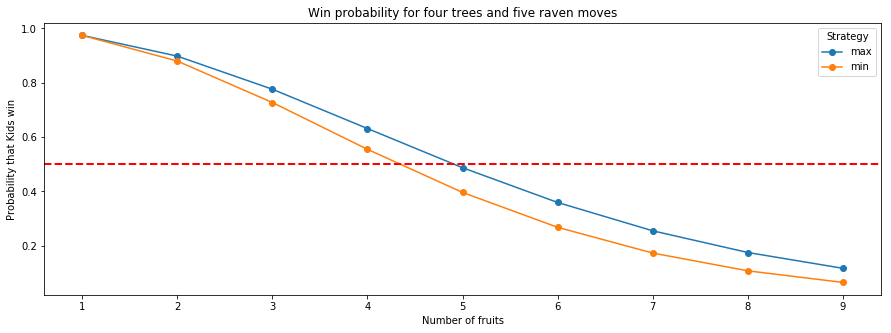

In [148]:
fig, ax = plt.subplots(figsize=(15, 5))

fruits = range(1, 10)
raven_moves = range(1, 8)

for strategy, name in zip([strategy_argmax, strategy_argmin], ['max', 'min']):
    
    probas = [
        Game(n_raven_moves=5, n_trees=4, n_fruits=i, strategy=strategy).compute_win_probability() for i in fruits
    ]    
    ax.plot(fruits, probas, label='{}'.format(name), marker='o')
    
ax.axhline(0.5, linewidth=2, color='red', linestyle='--')
ax.set_title('Win probability for four trees and five raven moves')
ax.set_xlabel('Number of fruits')
ax.set_ylabel('Probability that Kids win')
ax.legend(title="Strategy")

### Sampling win probability of random strategy

The random strategy is when kids select a fruit randomly from the available fruits once the basket is diced and we pretend that they act perfectly uniform at random (which, of course, is not what they do).

To correctly model this strategy, we have to update our game a bit by slightly making a fruit selection more likely, namely

In our example above, each traversal with points to a decreased fruit tree, the probability is not $\frac{1}{5}$, but $\frac{1}{5}+\frac{1}{5}\cdot\frac{1}{3}=\frac{4}{15}$

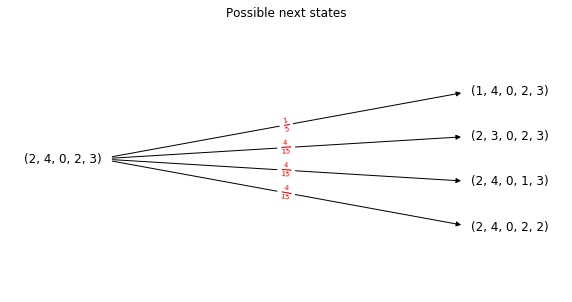

In [145]:
_, ax = plt.subplots(figsize=(10, 5))
ax.set_ylim([-3, 3])
ax.set_xlim([-1.5, 1.5])

traversals = {
    (1, 2): r'$\frac{1}{5}$', 
    (1, 3): r'$\frac{4}{15}$',
    (1, 4): r'$\frac{4}{15}$',
    (1, 5): r'$\frac{4}{15}$' 
}

nx.draw(G, pos, node_color='white', ax=ax, node_size=500)
nx.draw_networkx_labels(G, label_positions, labels=labels, ax=ax)
nx.draw_networkx_edge_labels(G, pos, edge_labels=traversals,font_color='red')
ax.set_title('Possible next states');

In [146]:
class RandomGame(Game):
    
    def _compute_probability_for_state(self, state):
        """
        Computes the Winning probability of the kids at the given state by using the winning 
        probabilities of the next states multiplied with the traversal probabilities induces 
        by the strategy
        """
        # Ignore the strategy move
        neighbor_states = list(state.get_next_states(self.strategy))[:-1]
        n_all_states = len(neighbor_states)
        n_possible_states = n_all_states + 1
        
        proba = 1/n_possible_states * self._get_probability(neighbor_states[0])
        
        return proba + (n_possible_states - 1)/n_possible_states / (n_all_states-1) *sum(
            [
                self._get_probability(neighbor) for neighbor in neighbor_states[1:]
            ]
        )

In [149]:
probas = [
    RandomGame(n_raven_moves=5, n_trees=4, n_fruits=i).compute_win_probability() for i in fruits
]  

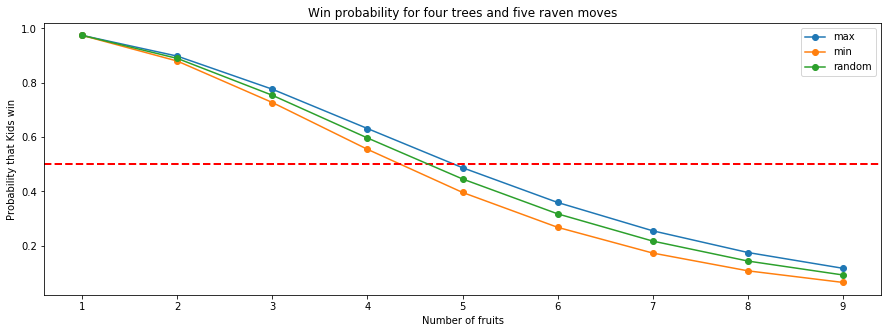

In [150]:
ax.plot(fruits, probas, label="random", marker='o')
ax.legend()
fig

Selecting randomly is better than the argmin strategy, but not as good as the argmax stragety. 

**To sum up**, even if the kids don't know what to do, they still beat the raven on average!